In [1]:
import numpy as np
import pandas as pd
import sqlite3
import datetime
from matplotlib import pyplot as plt

from sklearn import manifold
from sklearn.cluster import KMeans

In [2]:
def out_date(year):
    year = year.split('-')
    last_day = datetime.datetime(int(year[0]),int(year[1]),int(year[2]))
    zone = datetime.timedelta(7)
    return datetime.datetime.strftime(last_day + zone, "%Y-%m-%d")

In [3]:
def get_days(week_range):
    days = []
    days.append(input("YY-MM-DD: "))
    for i in range (week_range*52):
        days.append(out_date(days[-1]))
    return days

In [4]:
def get_names(c,days):
    names = []
    cursor = c.execute('''SELECT DISTINCT id FROM basic_information WHERE entry_day < ? ORDER BY RANDOM() limit 200''',[days[0]])
    for row in cursor:
        for i in row:
            names.append(row[0])
    return names

In [5]:
def get_NAV(c,names,days):
    NAV = []
    for name in names:
        temp = []
        for day in days:
            cursor = c.execute("SELECT NAV FROM price WHERE date <= ? AND id = ? ORDER BY date DESC LIMIT 1",[day,name])
            for row in cursor:
                temp.append(row[0])
        NAV.append(temp)
    
    for i in range(10):  
        for row in NAV:
            if len(row) !=53:
                NAV.remove(row)
            
    return NAV

In [6]:
def get_rate(NAV):
    rate = []
    for row in NAV:
        temp = []
        for i in range (52):
            num = (row[i+1] - row[i])/row[i]
            num = round(num,6)
            temp.append(num)
        rate.append(temp)
    
    for row in rate:
        if np.cov(row) == 0 and np.cov(row) == 0:
            rate.remove(row)
    
    return rate

In [7]:
def get_distance(rate):
    distance = []
    for i in rate:
        temp = []
        for j in rate:
            corr= np.corrcoef(i,j)
            corr = corr[0][-1]
            if i == j:
                corr = 1
            temp.append(1-(corr*0.5+0.5))
        distance.append(temp)
    return distance

In [8]:
def color_label(length):
    color = []
    color.append(1)
    color.append(2)
    color.append(3)
    color.append(4)
    
    for i in range(length-4):
        color.append(5)
        
    color = np.ndarray((length,), buffer=np.array(color),dtype=int)
    
    return color

In [9]:
def mds_draw(distance):
    mds = manifold.MDS(n_jobs=3,dissimilarity="precomputed")
    pos = mds.fit(distance).embedding_
    
    plt.scatter(pos[:, 0], pos[:, 1], c=color_label(len(pos[:, 0])), lw=0)
    plt.xlim(-0.55,0.55)
    plt.ylim(-0.55,0.55)
    plt.show()

In [10]:
def get_MDS():
    conn = sqlite3.connect('fund.db')
    c = conn.cursor()
    week_range = input("總共要幾個range: ")
    week_range = int(week_range)
    days = get_days(week_range)
    for i in range(week_range):
        names = get_names(c,days[i:i+53])
        NAV = get_NAV(c,names,days[i:i+53])
        rate = get_rate(NAV)
        distance = get_distance(rate)
        mds_draw(distance)
    conn.close()

總共要幾個range: 5
YY-MM-DD: 2008-10-01


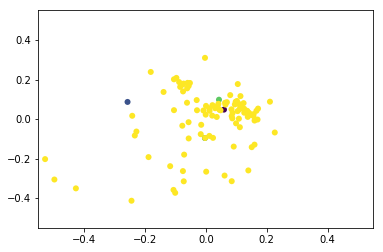

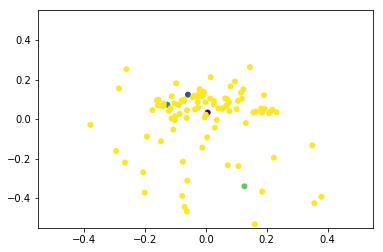

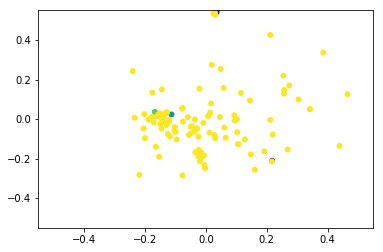

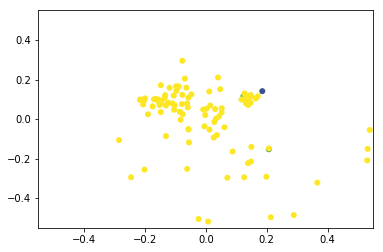

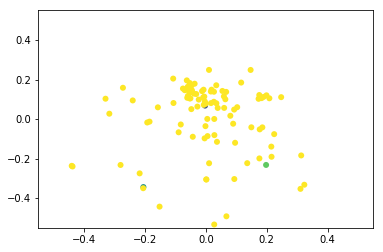

In [12]:
get_MDS()

In [ ]:
conn = sqlite3.connect('fund.db')
c = conn.cursor()
week_range = input("總共要幾個range: ")
week_range = int(week_range)
days = get_days(week_range)
for i in range(week_range):
    names = get_names(c,days[i:i+53])
    NAV = get_NAV(c,names,days[i:i+53])
    rate = get_rate(NAV)
    distance = get_distance(rate)
    mds = manifold.MDS(n_jobs=3,dissimilarity="precomputed")
    pos = mds.fit(distance).embedding_
        
    clf = KMeans(n_clusters=4)
    clf.fit(pos)
    plt.scatter(pos[:,0],pos[:,1], c=clf.labels_)
    plt.show()
conn.close()